In [1]:
import sys
import numpy as np
import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
import copy
np.random.seed(1)

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[LFR]'


**Load data**

In [2]:
df = pd.read_csv('adult.csv')

**Pre-processing**

In [ ]:
# check columns that have missing values\n
df.isin(['?']).sum(axis=0)

# replace missing values (?) to nan and then drop the columns
df['native.country'] = df['native.country'].replace('?',np.nan)
df['workclass'] = df['workclass'].replace('?',np.nan)
df['occupation'] = df['occupation'].replace('?',np.nan)

# dropping the NaN rows now
df.dropna(how='any',inplace=True)

df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0}).astype(int)

**One-hot encoding**

In [18]:
df = pd.concat([df, pd.get_dummies(df['race'], prefix='race')],axis=1)
df = pd.concat([df, pd.get_dummies(df['marital.status'], prefix='marital')],axis=1)
df = pd.concat([df, pd.get_dummies(df['workclass'], prefix='workclass')],axis=1)
df = pd.concat([df, pd.get_dummies(df['relationship'], prefix='relationship')],axis=1)
df = pd.concat([df, pd.get_dummies(df['education'], prefix='education')],axis=1)
df = pd.concat([df, pd.get_dummies(df['occupation'], prefix='occupation')],axis=1)

# age binning
df['ageUnder18'] = np.where(df['age'] < 18, 1, 0)
df['age18to24'] = np.where((df['age'] >= 18) & (df['age'] <= 24), 1, 0)
df['age25to44'] = np.where((df['age'] >= 25) & (df['age'] <= 44), 1, 0)
df['age45to64'] = np.where((df['age'] >= 45) & (df['age'] <= 64), 1, 0)
df['ageAbove65'] = np.where(df['age'] >= 65, 1, 0)

df = df.drop(columns=['workclass', 'fnlwgt', 'education', 'education.num', 'occupation', \
                      'relationship', 'marital.status', 'race', 'native.country', 'capital.gain', \
                      'capital.loss', 'hours.per.week', 'age'])

**Privileged, unprivileged**


In [ ]:
# privileged, unprivileged groups
privileged_groups = [{'sex': 1}] # Male
unprivileged_groups = [{'sex': 0}] # Female

**Function to compute fairness metrics**

In [19]:
def get_metrics(test_df, y_pred, unprivileged_groups, privileged_groups):
    # BLD constructor is taking arguments of Structured dataset
    test_bld = BinaryLabelDataset(df=test_df, label_names=['income'], protected_attribute_names=['sex'])
    
    # Made a copy of the the bld dataset
    pred_data = test_bld.copy()
    pred_data.labels = y_pred

    metric_selection = ClassificationMetric(
                    test_bld, pred_data,
                    unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)
    
    tnr_diff = metric_selection.true_negative_rate(1) - metric_selection.true_negative_rate(0)
    
    return [metric_selection.true_positive_rate_difference(), \
        metric_selection.statistical_parity_difference(),\
        tnr_diff,\
        metric_selection.accuracy()]

**k-fold cross-validation**

In [20]:
X = df.drop(columns='income')
y = df['income']

num_k = 5 # number of folds for cross-validation

# Metrics for each set of (train and test) sample
metrics = [None] * num_k

# Regression on original data
k_fold = KFold(n_splits=num_k, random_state=None, shuffle=False)
for k, (train, test) in enumerate(k_fold.split(X, y)):
    # Here train and test are the list of indices on which split is done
    # take out test set from X
    test_df = X.iloc[test].copy()
    test_df['income'] = y.iloc[test]
    
    reg = LogisticRegression(max_iter=300, solver = 'lbfgs')
    reg.fit(X.iloc[train], y.iloc[train])
    y_pred = reg.predict(X.iloc[test])
    metrics[k] = get_metrics(test_df, y_pred, unprivileged_groups, privileged_groups)

print("Results: Original")
mf_orig = pd.DataFrame(metrics, columns = ['TruePositiveRateDiff', 'StatisticalParityDiff', \
                                      'TrueNegativeRateDiff', 'Accuracy'])
mf_orig.mean()

Results: Original


TruePositiveRateDiff    -0.135077
StatisticalParityDiff   -0.181838
TrueNegativeRateDiff    -0.088531
Accuracy                 0.825942
dtype: float64

**Fairness metric to retrieve, threshold on metric for iterations**

In [21]:
metricIndex = 1
threshold = 0.0001

**Function to get a set of predicates such that removing tuples that satisfy these predicates will decrease parity difference**

In [22]:
def getPredicates(X_train, y_train, X_test, y_test, f_0):    
    attrList = []
    found = True
    f_curr = f_0
    
    print("Size of X_train: ", len(X_train))
    
    K = X_train.columns
    while (len(K) > 0 and found):
        found = False
        results = getAttribute(X_train, y_train, K, X_test, y_test, f_curr)
        attrK = results[0]
        f = results[1]
        indices = results[2]

        if (attrK is not None):
            K = K.drop(attrK)
            attrList.insert(len(attrList), attrK)
            f_curr = f
            X_train = X_train.drop(indices)
            y_train = y_train.drop(indices)
            print("Selected k: ", attrK)
            print("f: ", f)
            print("Size of X_train: ", len(X_train))
            found = True
            
    return attrList

**Function to return the <attribute, val> pair removing which will result in the minimum parity difference**
Note that our search is for the pair that has the least absolute parity difference.

In [23]:
# binary attributes
def getAttribute(X_train, y_train, K, X_test, y_test, f):
    attrK = None
    f_curr = f
    indices = []
#     removeTupleIndices = []
    
    reg = LogisticRegression(max_iter=300, solver = 'lbfgs')
    for col in K:
        removeTupleIndices = X_train[X_train[col] == 1].index

        X_train_temp = X_train.drop(removeTupleIndices, inplace = False)
        y_train_temp = y_train.drop(removeTupleIndices, inplace = False)

        reg.fit(X_train_temp, y_train_temp)
        y_pred = reg.predict(X_test)

        f_i = get_metrics(pd.concat([X_test, y_test], axis=1), y_pred, privileged_groups, unprivileged_groups)[metricIndex]
        if ((abs(f_i) < abs(f_curr)) and (abs(f_i) > threshold)) : #closer to 0 implies fairer
            attrK = col
            f_curr = f_i
            indices = copy.deepcopy(removeTupleIndices)
#             print("attrK: ", attrK)
#             print("f_curr: ", f_curr)
    
    return [attrK, f_curr, indices]

**Train, test split**

Original parity difference

In [24]:
train, test = train_test_split(df, test_size = 0.2)

X_train = train.drop(columns='income')
y_train = train['income']

X_test = test.drop(columns='income')
y_test = test['income']

reg = LogisticRegression(max_iter=300, solver = 'lbfgs')
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
f_orig = get_metrics(test, y_pred, unprivileged_groups, privileged_groups)

X_train_orig = copy.deepcopy(X_train)
y_train_orig = copy.deepcopy(y_train)
X_test_orig = copy.deepcopy(X_test)
y_test_orig = copy.deepcopy(y_test)

[-0.10686055672268907, -0.16753487179888252, -0.07622049167709677, 0.8312613956572187]


**Get predicates on training data**

In [25]:
attrList = getPredicates(X_train, y_train, X_test, y_test, f_orig[metricIndex])

Size of X_train:  24129
Selected k:  sex
f:  0.045699596819462854
Size of X_train:  7848
Selected k:  workclass_Private
f:  -0.007870358573597164
Size of X_train:  1704
Selected k:  workclass_State-gov
f:  -0.0021318287583951823
Size of X_train:  1313
Selected k:  education_10th
f:  -0.00020927242072056595
Size of X_train:  1292
Selected k:  marital_Married-civ-spouse
f:  -0.0002039743847529591
Size of X_train:  1016
Selected k:  workclass_Federal-gov
f:  0.00015654434847150404
Size of X_train:  797


['sex',
 'workclass_Private',
 'workclass_State-gov',
 'education_10th',
 'marital_Married-civ-spouse',
 'workclass_Federal-gov']

**<Attribute, metric> for each attribute**

Remove tuples satisfying attribute=1 and record new fairness metric

In [32]:
K = X_train_orig.columns
attrList = []
for col in K:
    removeTupleIndices = X_train_orig[X_train_orig[col] == 1].index

    X_train_temp = X_train_orig.drop(removeTupleIndices, inplace = False)
    y_train_temp = y_train_orig.drop(removeTupleIndices, inplace = False)

    reg.fit(X_train_temp, y_train_temp)
    y_pred = reg.predict(X_test)

    f_i = get_metrics(pd.concat([X_test, y_test], axis=1), y_pred, privileged_groups, unprivileged_groups)[metricIndex]
    attrList.insert(len(attrList), [col, abs(f_i)])

**Sort <attribute, metric> pairs in increasing order of metric** 

In [39]:
df = pd.DataFrame(attrList, columns = ['col', 'fval'])
df_sorted = df.sort_values(by=['fval'])

**Top-k heuristic**

Remove tuples satisfying predicates in increasing order of parity difference

In [58]:
def topkAttributes(X_train_orig, y_train_orig, df_sorted, k_num):
    X_train_temp = copy.deepcopy(X_train_orig)
    y_train_temp = copy.deepcopy(y_train_orig)

    for k in range(k_num):
        col = df_sorted.iloc[k]['col']
        removeTupleIndices = X_train_temp[X_train_temp[col] == 1].index

        X_train_temp = X_train_temp.drop(removeTupleIndices, inplace = False)
        y_train_temp = y_train_temp.drop(removeTupleIndices, inplace = False)

        reg.fit(X_train_temp, y_train_temp)
        y_pred = reg.predict(X_test)

        f_i = get_metrics(pd.concat([X_test, y_test], axis=1), y_pred, privileged_groups, unprivileged_groups)[metricIndex]
        print(col)
        print(f_i)
        print(len(X_train_temp))
        
topkAttributes(X_train_orig, y_train_orig, df_sorted, 5)

sex
0.045699596819462854
7848
marital_Married-civ-spouse
-0.010756652882522613
6674
age45to64
-0.01067264116932195
5044
education_Bachelors
-0.0029166949438824462
4246
workclass_Private
-2.9139197821851314e-05
689


In [ ]:
def get_attribute_fair(X_train, y_train, X_test, y_test, f):
    attrList = []
#     removeTupleIndices = []
    K = X_train.columns
    reg = LogisticRegression(max_iter=300, solver = 'lbfgs')
    for col in K:
        removeTupleIndices = X_train[X_train[col] == 1].index

        X_train_temp = X_train.drop(removeTupleIndices, inplace = False)
        y_train_temp = y_train.drop(removeTupleIndices, inplace = False)

        reg.fit(X_train_temp, y_train_temp)
        y_pred = reg.predict(X_test)

        f_i = get_metrics(pd.concat([X_test, y_test], axis=1), y_pred, privileged_groups, unprivileged_groups)[metricIndex]
        
        if (abs(f_i) > abs(f)):
            attrList.insert(len(attrList), [col, f_i])
    
    attr = pd.DataFrame(attrList, columns = ['Attribute', 'Inf'])
    
    return attr

In [22]:
# Returns the fairness after removing topK attributes
def getTopKFairness(X_train, y_train, X_test, y_test, f, k, attr):
    K = X_train.columns
    reg = LogisticRegression(max_iter=300, solver = 'lbfgs')
    
    attr_temp = attr.nlargest(k, 'Inf')
    attrList = attr_temp.values.tolist()
 
    for i in range(0 , len(attrList)) :
        col = attrList[i][0]
        removeTupleIndices = X_train[X_train[col] == 1].index
        
        X_train = X_train.drop(removeTupleIndices, inplace = False)
        y_train = y_train.drop(removeTupleIndices, inplace = False)
        
        print(len(X_train))
       
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    f_i = get_metrics(pd.concat([X_test, y_test], axis=1), y_pred, privileged_groups, unprivileged_groups)[metricIndex]
    
    return f_i

In [14]:
attr = get_attribute_fair(X_train, y_train, X_test, y_test, f_orig[metricIndex])

23018
23018
15212
23018
15212
13644
23018
15212
13644
8989
23018
15212
13644
8989
8756
23018
15212
13644
8989
8756
8290
23018
15212
13644
8989
8756
8290
7935
23018
15212
13644
8989
8756
8290
7935
6614
23018
15212
13644
8989
8756
8290
7935
6614
4605
23018
15212
13644
8989
8756
8290
7935
6614
4605
4337
23018
15212
13644
8989
8756
8290
7935
6614
4605
4337
3914
23018
15212
13644
8989
8756
8290
7935
6614
4605
4337
3914
3746
23018
15212
13644
8989
8756
8290
7935
6614
4605
4337
3914
3746
3565
23018
15212
13644
8989
8756
8290
7935
6614
4605
4337
3914
3746
3565
3534
23018
15212
13644
8989
8756
8290
7935
6614
4605
4337
3914
3746
3565
3534
3421
23018
15212
13644
8989
8756
8290
7935
6614
4605
4337
3914
3746
3565
3534
3421
3285
23018
15212
13644
8989
8756
8290
7935
6614
4605
4337
3914
3746
3565
3534
3421
3285
3140
23018
15212
13644
8989
8756
8290
7935
6614
4605
4337
3914
3746
3565
3534
3421
3285
3140
2974
23018
15212
13644
8989
8756
8290
7935
6614
4605
4337
3914
3746
3565
3534
3421
3285
3140
2974
2

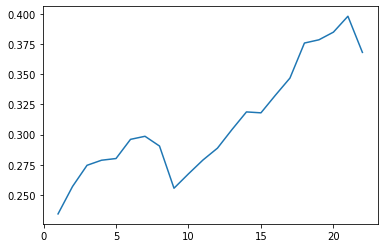

In [25]:
k = []
fair_inc = []
for i in range(1, len(attr)) :
    f_inc = getTopKFairness(X_train, y_train, X_test, y_test, f_orig[metricIndex], i, attr)
    k.insert(len(k), i)
    fair_inc.insert(len(fair_inc), f_inc)

fig, ax = plt.subplots()
ax.plot(k, fair_inc)
plt.show()